<a href="https://colab.research.google.com/github/AnIsAsPe/RNN-Resumenes-de-Texto/blob/main/Notebooks/Resumen_de_textos_usando_seq2seq_LSTM_w2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar bibliotecas

In [2]:
!pip install contractions

     |████████████████████████████████| 283 kB 35.8 MB/s 
     |████████████████████████████████| 321 kB 42.9 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85448 sha256=cdb02353606ff5eded4142495b01ac75ded4087e7e3cf8873d9cb086d6a3a1fd
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [3]:
import pandas as pd
import numpy as np

import gensim
import contractions
import re

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

## Descomprimir archivo

In [ ]:
#from zipfile import ZipFile
#with ZipFile('/content/drive/MyDrive/Datos/ReviewsAmazon.csv.zip', 'r') as zip_ref:
#    zip_ref.extractall('/content/drive/MyDrive/Datos/AmazonReviews')

# Leer datos de entrada

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datos/AmazonReviews/Reviews.csv',
                 nrows=100000, usecols=['Summary', 'Text'], )
df = df.drop_duplicates(keep='first', ignore_index = True).dropna()
print(df.shape)
df.head()

(88563, 2)


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 43982
Just like Girl Scout cookies
Exactly the same except you can get them year round when you order them online or get them in the store. I love them but you have to love chocolate and coconut and caramel!

Review # 18527
Love it!
I love this tea - bold and smooth. I love the fact that you can use the tea leaves for more than one steep. It really makes it go a long way. I will be getting this again!

Review # 66797
Not a good way to use green tea!
I use this brand of gum - favorite is Cinnamon and others are good, except this one.  Not a good way to use green tea in my opinion.  I will just drink mine.  Don't judge this brand by this flavor.

Review # 24657
Anise candy.
I like this candy.  Supposedly it is anise flavored.  The local Greek resturant, Apollo, has it; and I got used to it.  I was able to track it down through Amazon.

Review # 3505
HOT COCOA
Well the product was good and the taste is great. The convenience was excellent and the delivery was quick. So what's no

In [ ]:
df.to_csv('Amazon_reviews_trim.csv', index=False)

# Preprocesamiento de texto
- convertir a minuscualas
- expandir contracciones
- eliminar puntuación


In [ ]:
def preprocesar(texto):
    #quitar contracciones
    texto = contractions.fix(texto)

    #convertir en minúsculas
    texto = texto.lower()

    # eliminar texto no deseado
    texto = re.sub(r'<br />', ' ', texto)

    #texto = re.sub(r'https?:\/\/.*[\r\n]*', '', texto, flags=re.MULTILINE)
    #texto = re.sub(r'\<a href', ' ', texto)
    #texto = re.sub(r'&amp;', '', texto) 
    #texto = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', texto)
    #texto = re.sub(r'\'', ' ', texto)

    #dejar solo letras y números
    texto = re.sub('[^A-ZÜÖÄa-z0-9]+', ' ', texto)
    return(texto)

In [ ]:
%%time
for col in df.columns:
  df[col] = df[col].apply(preprocesar)
  
df.loc[738,'Text']

CPU times: user 5.47 s, sys: 18.5 ms, total: 5.49 s
Wall time: 5.5 s


In [ ]:
df['Summary'] = df['Summary'].apply(lambda x : 'tokenstart '+ x + ' tokenend')  #Identificador de comienzo y término

In [ ]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 84175
tokenstart yummy chips but not all that different  tokenend
these chips are very good crunchy and tasty just the right amount of salt yet i really do not see much of a difference as far as the chip being any healthier or a lot more tasty than other kettle chips they leave your fingers very greasy i guess all kettle chips do that though the bottom of every bag was full of broken greasy pieces of chip maybe my shipment just got banged around too much they do taste good and it is hard to put them down i finish off a bag every time i open one i am not a big eater either i try to eat a sandwich with them as to not polish off a whole bag at one setting overall i would try these again 

Review # 10927
tokenstart excellent  tokenend
great to send to my son a college student easy to fix and very tasty 

Review # 29534
tokenstart keeps my doggies entertained  tokenend
both of my chihuahua mutts love these inserts i use the treat in a bendo ball for one and she is busy for hours t

# Limitar la cantidad de palabras en textos y resumenes

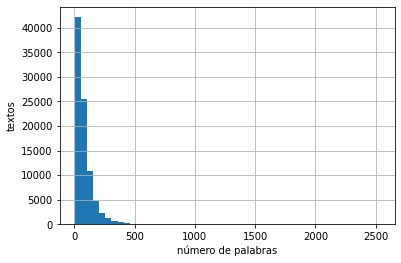


El 90% de los textos tiene 168 palabras


In [ ]:
# ¿Cuantas palabras tienen cada texto?
palabras_textos = df['Text'].apply(lambda x: len(str(x).split()))

hist = palabras_textos.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("textos")
plt.show()

print('\nEl 90% de los textos tiene {:,.0f} palabras'.format(palabras_textos.quantile(0.90)))

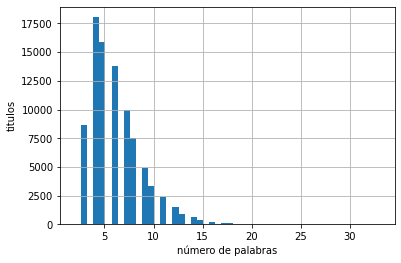


El 97.5% de los titulos tiene 13 palabras


In [ ]:
# ¿Cuantas palabras tienen cada titulo?
palabras_titulos = df['Summary'].apply(lambda x: len(str(x).split()))

hist = palabras_titulos.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("titulos")
plt.show()

print('\nEl 97.5% de los titulos tiene {:,.0f} palabras'.format(palabras_titulos.quantile(0.975)))

In [ ]:
longitud_max_textos = palabras_textos.quantile(0.90)     #168 palabras
longitud_max_titulos = palabras_titulos.quantile(0.975)  # 13 palabras

In [ ]:
datos =  df[(palabras_textos <= longitud_max_textos ) & (palabras_titulos <= longitud_max_titulos)]
datos.shape   

(78666, 2)

# Dividir datos en conjunto de entrenamiento y prueba

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(datos['Text'], 
                                                    datos['Summary'], 
                                                    test_size=0.1, 
                                                    shuffle=True, 
                                                    random_state=0)

In [ ]:
print('{} reseñas en el conjunto de entrenamiento\n{} reseñas en el conjunto de prueba'.format(len(x_train), len(x_test)))

70799 reseñas en el conjunto de entrenamiento
7867 reseñas en el conjunto de prueba


# Vectorización del texto

[Referencia](https://keras.io/examples/nlp/pretrained_word_embeddings/):


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization  
from tensorflow.data import Dataset

### Paso 1 Diccionario de vocabulario con clave y vectorizador de textos

In [ ]:
def genera_dic_vocabulario(serie_pd, max_tokens= 20000):
  '''Obtiene el vocabulario de una serie de pandas con textos en forma de 
  diccionario, donde cada palabra es una clave y el valor es un indice'''
  vectorizer = TextVectorization(max_tokens = max_tokens  )  
  text_ds = Dataset.from_tensor_slices(serie_pd).batch( 128)  
  vectorizer.adapt(text_ds)   #similar a fit 
  voc = vectorizer.get_vocabulary()  # lista con el vocabulario
  #diccionario con el vocabulario
  dic_vocabulario = dict(zip(voc, range(len(voc))))
  return dic_vocabulario, vectorizer

In [ ]:
%%time
vocabulario_dic, vectorizer_reseña = genera_dic_vocabulario(x_train)

CPU times: user 3.56 s, sys: 518 ms, total: 4.08 s
Wall time: 8.75 s


In [ ]:
ejemplos = ['got', 'wild', 'hair', 'ordered', 'pound', 'bag']
[vocabulario_dic[palabra] for palabra in ejemplos]

[142, 1200, 590, 160, 666, 112]

In [ ]:
vectorizer_reseña(ejemplos)

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[ 142],
       [1200],
       [ 590],
       [ 160],
       [ 666],
       [ 112]])>

In [ ]:
vocabulario_dic.keys()

dict_keys(['', '[UNK]', 'the', 'i', 'and', 'a', 'it', 'to', 'is', 'of', 'this', 'not', 'for', 'in', 'my', 'have', 'that', 'but', 'are', 'you', 'with', 'was', 'they', 'as', 'like', 'these', 'on', 'so', 'them', 'good', 'great', 'taste', 'will', 'very', 'be', 'at', 'product', 'just', 'one', 'do', 'or', 'would', 'flavor', 'if', 'all', 'coffee', 'we', 'am', 'love', 'from', 'can', 'tea', 'when', 'has', 'more', 'had', 'me', 'than', 'amazon', 'no', 'out', 'get', 'really', 's', 'other', 'too', 'food', 'only', 'up', 'some', 'much', 'about', 'were', 'buy', 'price', 'little', 'best', 'because', 'time', 'an', 'use', 'there', 'tried', 'also', 'find', 'your', 'did', 'what', 'better', 'chocolate', 'make', 'well', 'he', 'been', 'does', 'even', 'try', 'she', 'dog', 'eat', 'which', 'by', 'after', 'now', 'any', 'again', 'drink', 'our', 'could', 'sweet', 'sugar', 'bought', 'bag', 'found', 'first', 'cup', '2', 'used', 'cannot', 'their', 'her', 'tastes', 'made', 'order', 'free', 'delicious', 'store', 'box', 

In [ ]:
len(vocabulario_dic)

20000

[UNK] se usa para cuando en nuevos ejemplos existan palabras que no se enciuentren en el diccionario.

### Paso 2 Diccionario con vectores de palabras (embeddings) Word2Vec# 
Bajaremos los vectores word2vec preentrenados con el corpus GoogleNews.
Cuenta con 3 millones vectores de 300 dimensiones correspondientes a 3  palabras y frases en inglés


Referencia uso word embedings preentrenados con Keras en este [enlace](https://keras.io/examples/nlp/pretrained_word_embeddings/)


In [ ]:
#!wget wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
#!gunzip /content/GoogleNews-vectors-negative300.bin.gz -d /content/drive/MyDrive/Datos/Embeddings/

In [ ]:
from gensim.models import KeyedVectors  #comparación keyedVectors y fullmodels https://radimrehurek.com/gensim/models/keyedvectors.html

w2v = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Datos/Embeddings/GoogleNews-vectors-negative300.bin',
                                                        binary=True)

In [ ]:
%%time
dic_embeddings_word2vec  = {palabra : w2v[palabra] for palabra in w2v.index2word}

CPU times: user 5.66 s, sys: 287 ms, total: 5.94 s
Wall time: 5.95 s


In [ ]:
#Cantidad de palabras en modelo word2vec
len(dic_embeddings_word2vec)

3000000

In [ ]:
print(dic_embeddings_word2vec ["got"].shape)
dic_embeddings_word2vec ["got"]

(300,)


array([ 0.06201172,  0.10839844, -0.09667969,  0.07910156,  0.03393555,
       -0.34765625, -0.06982422, -0.05249023, -0.1328125 ,  0.19140625,
       -0.04882812, -0.25195312, -0.00817871, -0.00964355, -0.05444336,
       -0.02270508,  0.10498047,  0.24511719,  0.01953125,  0.06933594,
       -0.18652344,  0.13671875,  0.30664062, -0.07324219,  0.26953125,
       -0.04589844,  0.04223633, -0.02502441,  0.14941406,  0.09228516,
        0.07519531,  0.02160645, -0.1015625 , -0.03710938,  0.15234375,
        0.02807617,  0.11083984,  0.00108337,  0.01696777,  0.03540039,
       -0.05224609, -0.2890625 ,  0.2265625 ,  0.09423828, -0.01452637,
       -0.12451172, -0.01977539, -0.23144531,  0.08105469, -0.02453613,
       -0.19140625,  0.16015625,  0.00387573, -0.01293945,  0.02294922,
        0.16113281,  0.12792969,  0.05859375,  0.00805664, -0.12695312,
        0.07226562,  0.2109375 , -0.08154297, -0.14453125, -0.05615234,
        0.03442383,  0.03417969, -0.02844238, -0.05029297,  0.14

### Paso 3 Obtener la matriz de vectores para todas las palabras del vocabulario 
embedding_texto()

In [ ]:
def embedding_texto(dic_vocabulario, dic_embeddings_palabras, embedding_dim):
    num_tokens = len(dic_vocabulario.keys()) + 2  # se suman dos más para '' y '[UNK]'
    encontradas = 0
    # Inicializar matriz
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in dic_vocabulario.items():
        embedding_vector = dic_embeddings_palabras.get(word)
        if embedding_vector is not None:
            # los vectores no encontrados en el embeding se quedan en cero
            embedding_matrix[i] = embedding_vector
            encontradas += 1
    proporcion = encontradas/len(dic_vocabulario) *100
    print("{} palabras vectorizadas, que representan {:.1f}% de todas las palabras en el corpus".format(encontradas, proporcion))
    return embedding_matrix

In [ ]:
embedding_matrix = embedding_texto(vocabulario_dic, dic_embeddings_word2vec , 300)

17591 palabras vectorizadas, que representan 88.0% de todas las palabras en el corpus


In [ ]:
embedding_matrix.shape

(20002, 300)


**Repetiremos el paso 1 y el paso 3 para crear el diccionario de los Resumenes.(el diccionario con vectores GloVe es el mismo)**

In [ ]:
vocabulario_dic_sum, vectorizer_sum = genera_dic_vocabulario(y_train)
embedding_matrix_sum = embedding_texto(vocabulario_dic_sum, dic_embeddings_word2vec , 300)
embedding_matrix_sum.shape

10093 palabras vectorizadas, que representan 77.6% de todas las palabras en el corpus


(13003, 300)

## Paso 4. Preparar secuencia de entrada de la red neuronal


### Ejemplo de la transformación que necesitamos hacer

In [ ]:
ejemplos = datos.loc[5:7,'Text']
for ej in ejemplos:
  print(len(ej.split()))
  print(ej)

73
i got a wild hair for taffy and ordered this five pound bag the taffy was all very enjoyable with many flavors watermelon root beer melon peppermint grape etc my only complaint is there was a bit too much red black licorice flavored pieces just not my particular favorites between me my kids and my husband this lasted only two weeks i would recommend this brand of taffy it was a delightful treat 
51
this saltwater taffy had great flavors and was very soft and chewy each candy was individually wrapped well none of the candies were stuck together which did happen in the expensive version fralinger s would highly recommend this candy i served it at a beach themed party and everyone loved it 
24
this taffy is so good it is very soft and chewy the flavors are amazing i would definitely recommend you buying it very satisfying 


In [ ]:
ejemplos_vec = ejemplos.apply(vectorizer_reseña)
for ej in ejemplos_vec:
  print(len(ej))
  print(ej)

73
tf.Tensor(
[   3  142    5 1200  590   12 2757    4  160   10  726  666  112    2
 2757   21   44   33 1409   20  151  149 2370 1589 1206 7123 1332 1239
  481   14   67  998    8   81   21    5  140   65   70  493  332  852
  352  426   37   11   14  836  902  622   56   14  328    4   14  330
   10 1641   67  137  596    3   41  130   10  165    9 2757    6   21
    5 1650  207], shape=(73,), dtype=int64)
51
tf.Tensor(
[  10    1 2757   55   30  149    4   21   33  424    4  627  259  308
   21 1363  980   91  804    9    2  952   72 1069  720  100   86 1760
   13    2  291  500    1   63   41  233  130   10  308    3 1072    6
   35    5 3006 4570 1060    4  439  279    6], shape=(51,), dtype=int64)
24
tf.Tensor(
[  10 2757    8   27   29    6    8   33  424    4  627    2  149   18
  431    3   41  197  130   19  202    6   33  791], shape=(24,), dtype=int64)


Ahora forzaremos a que cada vector tenga el mismo largo

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences


ejemplos_seq =  pad_sequences(ejemplos_vec, maxlen = int(longitud_max_textos), padding='post')
for ej in ejemplos_seq:
  print(len(ej))
  print(ej)

168
[   3  142    5 1200  590   12 2757    4  160   10  726  666  112    2
 2757   21   44   33 1409   20  151  149 2370 1589 1206 7123 1332 1239
  481   14   67  998    8   81   21    5  140   65   70  493  332  852
  352  426   37   11   14  836  902  622   56   14  328    4   14  330
   10 1641   67  137  596    3   41  130   10  165    9 2757    6   21
    5 1650  207    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
168
[  10    1 2757   55   30  149    4   21   33  424    4  627  259  308
   21 1363  980   91  804    9    2  952   72 1069  720  100   86 17

### Transformación del conjunto de entrenamiento y del conjunto de prueba

In [ ]:
%%time
x_train_vec = x_train.apply(vectorizer_reseña)
x_test_vec = x_test.apply(vectorizer_reseña)

y_train_vec = y_train.apply(vectorizer_sum)
y_test_vec = y_test.apply(vectorizer_sum)

CPU times: user 13min 4s, sys: 1min 17s, total: 14min 22s
Wall time: 12min 18s


In [ ]:
%%time

x_train_seq  =  pad_sequences(x_train_vec, maxlen = int(longitud_max_textos), padding='post') 
x_test_seq  =  pad_sequences(x_test_vec, maxlen = int(longitud_max_textos), padding='post') 

y_train_seq  =  pad_sequences(y_train_vec, maxlen = int(longitud_max_titulos) , padding='post') 
y_test_seq  =  pad_sequences(y_test_vec, maxlen = int(longitud_max_titulos) , padding='post') 

CPU times: user 1min 7s, sys: 9.14 s, total: 1min 16s
Wall time: 1min


# Diseño del modelo

* [referencia1](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

* [referencia2](https://humboldt-wi.github.io/blog/research/information_systems_1920/nlp_text_summarization_techniques/) 

## Diseño del codificador y decodificador

Codificador 3 capas con 3 LTSM y 320 dimensiones latentes


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Concatenate, Attention
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import backend as K 


In [ ]:
num_tokens_rev = len(vocabulario_dic) + 2
num_tokens_sum = len(vocabulario_dic_sum) + 2
embedding_dim = 300

In [ ]:
K.clear_session() 
latent_dim = 320

# CODIFICADOR   ================================================================

## EMBEDDING
   #recibe la secuencia de entrada para obtener una matriz longitud máxima x dim_embedding
encoder_inputs = Input(shape = (int(longitud_max_textos),))

enc_emb_lay = Embedding(num_tokens_rev, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    trainable=False)
enc_emb = enc_emb_lay(encoder_inputs)     

#LSTM 1
  #recibe la matriz del embeding para obtener el estado oculto, 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 


# LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 


# DECODIFICADOR ================================================================

decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tokens_sum, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix_sum),
                    trainable=False)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM 
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 




##Attention Layer

Fuente: https://github.com/madhav727/abstractive-news-summary

In [ ]:
!cp drive/MyDrive/Datos/attention.py .


In [ ]:
from attention import AttentionLayer

In [ ]:
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])  #concatena los estados ocultos del codificador y del decodificador para construir el vector de contexto

## Union del modelo

In [ ]:
embedding_matrix_sum.shape

(13003, 300)

In [ ]:
embedding_matrix_sum.shape[0]

13003

In [ ]:
# Unión de la salida del decodificador(distribución del vocabulario proveniente de los resumenes
# y el vector de contexto del módulo de atención en la capa con activación softmax

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
decoder_dense = TimeDistributed(Dense(embedding_matrix_sum.shape[0], activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Modelo definitivo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 



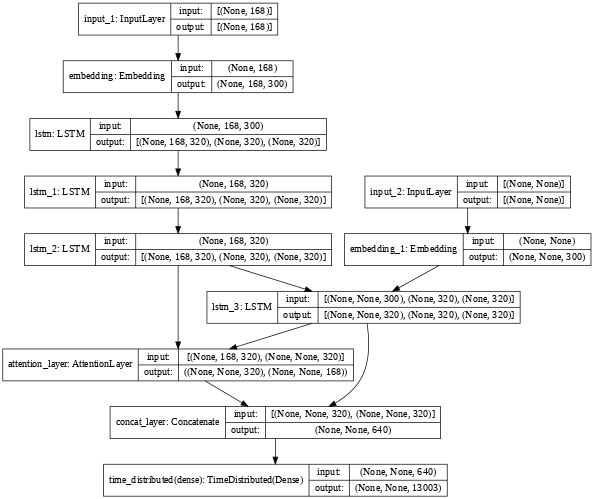

In [ ]:
tf.keras.utils.plot_model( 
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 168)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 168, 300)     6000600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 168, 320), ( 794880      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

# Entrenamiento del modelo

In [ ]:
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy')

In [ ]:
%%time

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1) 

history = model.fit([x_train_seq, y_train_seq[:,:-1]], 
                    y_train_seq.reshape(y_train_seq.shape[0],
                                        y_train_seq.shape[1], 1)[:,1:],
                    epochs = 20, 

                    #terminar antes cuando no disminuya la función de pérdida
                    #callbacks = [EarlyStopping(monitor='val_loss',mode='min', 
                    #                         verbose=1)],
                    batch_size = 512, 
                    validation_data = ([x_test_seq,y_test_seq[:,:-1]], 
                                     y_test_seq.reshape(y_test_seq.shape[0],
                                                        y_test_seq.shape[1],
                                                        1)[:,1:]))


Epoch 1/20
139/139 [==============================] - 140s 1s/step - loss: 2.2008 - val_loss: 2.0935
Epoch 2/20
139/139 [==============================] - 139s 1s/step - loss: 2.0321 - val_loss: 2.0088
Epoch 3/20
139/139 [==============================] - 140s 1s/step - loss: 1.9360 - val_loss: 1.9424
Epoch 4/20
139/139 [==============================] - 140s 1s/step - loss: 1.8529 - val_loss: 1.8750
Epoch 5/20
139/139 [==============================] - 141s 1s/step - loss: 1.7792 - val_loss: 1.8280
Epoch 6/20
139/139 [==============================] - 141s 1s/step - loss: 1.7188 - val_loss: 1.7936
Epoch 7/20
139/139 [==============================] - 141s 1s/step - loss: 1.6666 - val_loss: 1.7626
Epoch 8/20
139/139 [==============================] - 141s 1s/step - loss: 1.6199 - val_loss: 1.7417
Epoch 9/20
139/139 [==============================] - 141s 1s/step - loss: 1.5774 - val_loss: 1.7318
Epoch 10/20
139/139 [==============================] - 140s 1s/step - loss: 1.5370 - val_lo

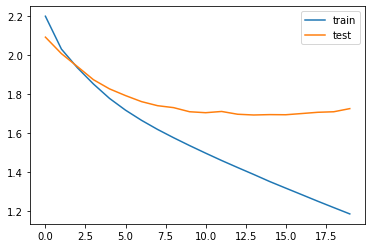

In [ ]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [ ]:
#Guardar todo el modelo
model.save('/content/drive/MyDrive/Modelos/rrn_modelo_LSTM_w2v')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Modelos/rrn_modelo_LSTM_w2v/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Modelos/rrn_modelo_LSTM_w2v/assets


In [ ]:
#modelo = tf.keras.models.load_model('/content/drive/MyDrive/Modelos/rrn_modelo_w2v')

# Check its architecture
#modelo.summary()

#Invertir diccionario de vocabulario
El objetivo es que a partir de indice, regrese palabras

In [ ]:
reversed_vocabulario_dic_sum = dict(map(reversed, vocabulario_dic_sum.items()))
reversed_vocabulario_dic_text = dict(map(reversed, vocabulario_dic.items()))


#Modelo de Inferencia y Generación de Texto

In [ ]:
## Inferencia del codificador
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Inferencia del decodificador

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(int(longitud_max_textos), latent_dim))

# Obtener los embeddings de la secuencia del decodificador 
dec_emb2 = dec_emb_layer(decoder_inputs)

# Para predecir la siguiente palabra, el estado inicial se iguala al estado del tiempo anterior
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#Inferencia en modulo de atención
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Se utiliza la capa con activación softmax para generar la distribución de probabilidad del vocabulario objetivo
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Modelo final del decoder
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

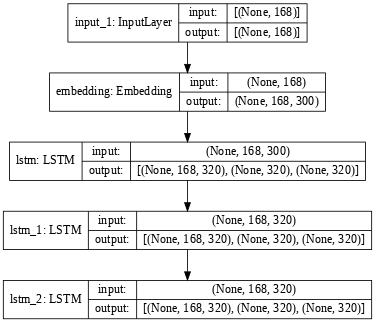

In [ ]:
tf.keras.utils.plot_model( 
    encoder_model,
    to_file="encoder_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

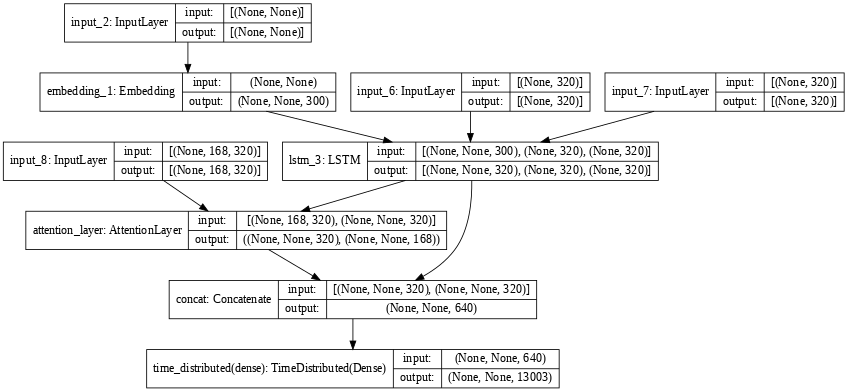

In [ ]:
tf.keras.utils.plot_model( 
    decoder_model,
    to_file="model_decoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

# Implementación del modelo de inferencia mediante decode_sequence()

[fuente](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

In [ ]:
def crea_resumen(input_seq):
    # Codifica el texto como vectores de entrada
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Genera una secuencia vacía de longitud 1.
    target_seq = np.zeros((1,1))

    # Identifica la palabra 'tokenstart' como la primera palabra de la secuencia objetivo
    target_seq[0, 0] =  vocabulario_dic_sum['tokenstart']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Escoje la proxima palabra para el resumen
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reversed_vocabulario_dic_sum[sampled_token_index]

        # Mientras la palabra elejida no sea la final 'tokenend', anexa la palabra elejida al resumen
        if sampled_token!='tokenend':
            decoded_sentence += ' '+sampled_token

        # Sal del ciclo while si se alcanza la longitud máxima o si se encuentra 'tokenend'.
        if (sampled_token == 'tokenend' or len(decoded_sentence.split()) >= (int(longitud_max_titulos-1))):
                stop_condition = True

        # Actualiza la secuencia objetivo (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Actualiza los estados internos para predecir la siguiente palabra, igualandolos al estado del tiempo anterior
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
      if((i != 0 and i != vocabulario_dic_sum['tokenstart']) and i != vocabulario_dic_sum['tokenend']):
        newString = newString + reversed_vocabulario_dic_sum[i]+' '
    return newString

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
      if(i != 0):
        newString = newString + reversed_vocabulario_dic_text[i]+' '
    return newString

In [ ]:
x_test.iloc[0]

'finally cat food that my cats are willing to consume without the side effects of diarrhea nausea or vomiting i will continue to purchase unless my kitty cats are requesting something else instead '

In [ ]:
y_test.iloc[0]

'tokenstart they like them they like them  tokenend'

In [ ]:
y_test.shape

(7867,)

In [ ]:
for i in range(10, 20):
  print(i)
  print("Review:",seq2text(x_test_seq[i]))
  print("Original summary:",seq2summary(y_test_seq[i]))
  print("Predicted summary:",crea_resumen(x_test_seq[i].reshape(1, -1)))
  print("\n")

10
Review: disclaimer i am reviewing a package that i received for free through the vine program well it is ok i probably would not buy it but i do not usually buy instant iced tea mixes anyway the fruit flavor is ok i cannot comment on the naturalness vs [UNK] of the ingredients etc like other reviewers i would probably just brew my own fresh green tea and chill it in the fridge 
Original summary: ok 
Predicted summary:  not as good as i expected


11
Review: i make a [UNK] pitcher of this tea for my family just about every day i use 15g of flowers 1 2 oz or a scant 1 2 cup per quart of tea so just about 1 5 cups of flower petals in my mr coffee tea maker i add [UNK] 10 servings of a href http www amazon com gp product [UNK] wholesome sweeteners organic raw blue agave 44 ounce bottle pack of 2 a right over the top of the petals before i set it to brew 60 calories per serving yummy 
Original summary: directions for a pitcher 
Predicted summary:  great tea


12
Review: lovely aroma good

In [ ]:
len(range(len(x_test[0:200])))

200

In [ ]:
%%time
Review = pd.Series(np.apply_along_axis(seq2text, 1, x_test_seq[:50]), name='Review')
Original_summary = pd.Series(np.apply_along_axis(seq2summary, 1, y_test_seq[:50]), name = 'Original_Summary')

Predicted_summary = pd.Series(name = 'Predicted_summary').reindex_like(Review)
for i in range(50):
  Predicted_summary[i] = crea_resumen(x_test_seq[i].reshape(1, -1))
Predicted_summary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


CPU times: user 10.9 s, sys: 358 ms, total: 11.3 s
Wall time: 11.1 s


In [14]:
Resultados = pd.concat([Review, Original_summary, Predicted_summary], axis=1)

Para guardar la tabla de resultados en un archivo, descomentar la siguiente linea, y reemplazar la ruta con la corresponeiente a la carpeta personal en el drive donde se quiera guardar.

In [ ]:
#Resultados.to_csv('/content/drive/MyDrive/Modelos/rrn_modelo_LSTM_w2v/Resultados/resultados_rnn.csv', index=False)

In [16]:
Resultados

,Review,Original_summary,Predicted_summary
0,finally cat food that my cats are willing to c...,they like them they like them,cat food
1,these are really delicious cookies and they ar...,yummy,great cookies
2,i cannot believe you guys jacked up the price ...,disappointed,great
3,i was starting to think that snyder and i just...,snyder s best flavor,yummy
4,this bar reminds me of the semi sweet chocolat...,mild and semi sweet,tasty but not as chocolate
5,the cashew cookie is my favorite flavor of the...,very tasty,delicious
6,i am happy with this purchase shiitake mushroo...,[UNK],great product
7,i love these low calorie snacks i count calori...,delicious,great snack
8,worst purchase i ever bought off of amazon and...,smelled like [UNK],horrible
9,i grew up in england moved here when i was 19 ...,pg tips is the only tea for me,best tea


# Evaluación con Rouge

In [5]:
!pip install Rouge

In [17]:
from rouge import Rouge

Para leer los resultados desde el archivo csv guardado en drive en la sección anterior

In [15]:
#Resultados = pd.read_csv('/content/drive/MyDrive/Modelos/rrn_modelo_LSTM_w2v/Resultados/resultados_rnn.csv')

In [21]:
Resultados

,Review,Original_summary,Predicted_summary
0,finally cat food that my cats are willing to c...,they like them they like them,cat food
1,these are really delicious cookies and they ar...,yummy,great cookies
2,i cannot believe you guys jacked up the price ...,disappointed,great
3,i was starting to think that snyder and i just...,snyder s best flavor,yummy
4,this bar reminds me of the semi sweet chocolat...,mild and semi sweet,tasty but not as chocolate
5,the cashew cookie is my favorite flavor of the...,very tasty,delicious
6,i am happy with this purchase shiitake mushroo...,[UNK],great product
7,i love these low calorie snacks i count calori...,delicious,great snack
8,worst purchase i ever bought off of amazon and...,smelled like [UNK],horrible
9,i grew up in england moved here when i was 19 ...,pg tips is the only tea for me,best tea


In [19]:
rouge = Rouge()

Se proporcionan resultados para dos tipos de métricas:
- ***rouge-n*** , evalúa los resultados usando n-gramas
- ***rouge-l***, evalúa en base a la secuencia más larga entre la referencia y el modelo

Además en cada tipo de métrica, se ealuá el modelo usando:
- $presición = \frac{n-gramas_{comunes} }{ n-gramas_{predicción}}$


- $recall = \frac{n-gramas_{comunes} }{ n-gramas_{referencia}}$

- $f1_{score} = 2*\frac{precision*recall }{precision+recall}$

In [61]:
model_out = Resultados['Predicted_summary']
reference = Resultados['Original_summary']

rouge.get_scores(model_out, reference)[0:5]

[{'rouge-1': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'rouge-l': {'f': 0.0, 'p': 0.0, 'r': 0.0}},
 {'rouge-1': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'rouge-l': {'f': 0.0, 'p': 0.0, 'r': 0.0}},
 {'rouge-1': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'rouge-l': {'f': 0.0, 'p': 0.0, 'r': 0.0}},
 {'rouge-1': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'rouge-l': {'f': 0.0, 'p': 0.0, 'r': 0.0}},
 {'rouge-1': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'rouge-l': {'f': 0.0, 'p': 0.0, 'r': 0.0}}]

In [41]:
index = 43

print('Referencia: ', reference[index])
print('Resumen modelo:', model_out[index],'\n')

print('Precisión: ', rouge.get_scores(model_out, reference)[index]['rouge-1']['p'])
print('Recall: ', rouge.get_scores(model_out, reference)[index]['rouge-1']['r'])
print('F1 score: ', rouge.get_scores(model_out, reference)[index]['rouge-1']['f'])

Referencia:  this is the best green tea i h
Resumen modelo:  great tea 

Precisión:  0.5
Recall:  0.125
F1 score:  0.19999999680000002


In [85]:
metrica = 'rouge-1'   # rouge-2  rouge-l

evaluacion_dict = {index: i[metrica]for index, i in zip(range(len(Resultados)), rouge.get_scores(model_out, reference))}
evaluation_df = pd.DataFrame.from_dict(evaluacion_dict, orient='index')
Resultados = pd.concat([Resultados, evaluation_df],axis=1)

In [88]:
Resultados.sort_values(by=['r'], ascending=False)

,Review,Original_summary,Predicted_summary,r,p,f
38,for the price this is one great cup of coffee ...,great cup of coffee,great coffee,0.500000,1.000000,0.666667
30,this is a great tasting and easy to prepare ma...,great tasting,great taste,0.500000,0.500000,0.500000
19,seriously get this marinade for all yer pork n...,amazing marinade,great marinade,0.500000,0.500000,0.500000
25,first off i hate to trash a product that is no...,good for [UNK] not so much for,great little pricey but not so much,0.500000,0.428571,0.461538
39,this is the best cereal i like to use it as a ...,[UNK] cereal,great cereal,0.500000,0.500000,0.500000
33,the grilled sirloin flavor was a winner for my...,dogs loved it,great for dogs with a,0.333333,0.200000,0.250000
46,we first discovered these pouches at our local...,great for the picky eater,great product,0.200000,0.500000,0.285714
40,i was recommended this product by a relative o...,not as amazing as i anticipate,not the best,0.200000,0.333333,0.250000
23,our standard schnauzer wants that peanut butte...,the pups seem to like them,my dog loves them,0.166667,0.250000,0.200000
37,this is a great tasting cereal it has a lastin...,great cereal not so good price,great,0.166667,1.000000,0.285714


ROUGE tiene la limitante de que es una evaluación sintáctica pero no semántica